<a href="https://colab.research.google.com/github/MohamadMahdiDarvishi/Tensorflow/blob/main/Notebooks/Tensorflow_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow part 1 : Feature Extraction

⚡ **Transfer Learning** :

Actully transfer learning means to use our model in real world's problems and not on our train and test datasets

❗ **Note**

also by transfer learning we could extract the architecture and important things that cause the accurate answers of those models

## 0. Pre-requirities

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import os
import pathlib
import random

In [ ]:
# device agnostic code
!nvidia-smi

Fri Sep  1 11:14:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Prepare Data

In [ ]:
import zipfile
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-09-01 11:14:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.9MB/s    in 8.7s    

2023-09-01 11:14:16 (18.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# walking through data folder and becoming one with data
for dirpath , dirname , dirfiles in os.walk("10_food_classes_10_percent") :
  print(f"in directory : {dirpath} there is  : {len(dirname)} directories and there is : {len(dirfiles)} files there")

in directory : 10_food_classes_10_percent there is  : 2 directories and there is : 0 files there
in directory : 10_food_classes_10_percent/test there is  : 10 directories and there is : 0 files there
in directory : 10_food_classes_10_percent/test/pizza there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/hamburger there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/chicken_wings there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/fried_rice there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/ice_cream there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/steak there is  : 0 directories and there is : 250 files there
in directory : 10_food_classes_10_percent/test/sushi there is  : 0 directories and there is : 250 files there
in direct

In [ ]:
# train and test folders
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Creating Data Generators (Data Loaders)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train data loader
train_data_gen = ImageDataGenerator(rescale = 1/255.0 ,
                                    width_shift_range = 0.2 ,
                                    height_shift_range = 0.2 ,
                                    horizontal_flip = True ,
                                    rotation_range = 0.2 ,
                                    shear_range = 0.2)
# test data loader
test_data_gen = ImageDataGenerator(rescale = 1/255.0)

In [ ]:
# train data
train_data = train_data_gen.flow_from_directory(directory = train_dir ,
                                                target_size = (224,224) ,
                                                class_mode = "categorical" ,
                                                seed = 42 ,
                                                shuffle = True ,
                                                batch_size = 32)
# test data
test_data = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size = (224,224) ,
                                              class_mode = "categorical" ,
                                              shuffle = False ,
                                              batch_size = 32)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## 2. Build model

### 2. 1 Create Call backs

callbacks are used to add extra functionality to our model including tracking model results , preventing model from overfitting and etc .

some of call backs that we are giong to use are :

* `TensorBoard` - Tracking expriments
* `ModelCheckpoint` - Creating checkpoints per epoch
* `EarlyStopping` - Stopping a model training (before it trains too long and overfits)

In [ ]:
# TensorBoard callback
import datetime

def tensorboard_callback_function(dir_name : str , expriment_name : str) :
  log_dir = dir_name + "/" + expriment_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to {log_dir}")
  return tensorboard_callback

### 2. 2 Create model using Tensorflow hub

in this section we are going to create most of model layers using tensorflow hub.

we could access to lot of pretrained models on [tensorflow hub](https://tfhub.dev/)

models we are going to create using Tnsorflow Hub :

* ResNet TensorFlow Hub Feature Extraction model
* EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# pretrained models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import
import tensorflow_hub as hub

# Create model function
def create_model(model_url , num_classes) :
  """
  Using tensorflow hub url links to create keras Sequential layers model with that

  Args :

    model_url (str) : tensorflow hub link of pretrained model
    num_classes (int) : number of classes that determines the number of neurons in output_layer

  Returns :

    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download pre-trained model and save it as KerasLayer
  feature_extractor_layer = hub.KerasLayer(trainable = False , # freeze model learned patterns
                                           handle = model_url ,
                                           input_shape = (224,224,3) ,
                                           name = "feature_extraction_layer")
  # Create model
  model = tf.keras.Sequential([
      feature_extractor_layer ,
      tf.keras.layers.Dense(num_classes , activation = tf.keras.activations.sigmoid , name = "output_layer")
  ])

  return model

**ResNet model**

In [ ]:
# 1 . create model
model_resnet = create_model(model_url = resnet_url ,
                            num_classes = 10)
# 2 . compile model
model_resnet.compile(loss = tf.keras.losses.categorical_crossentropy ,
                     optimizer = tf.keras.optimizers.Adam() ,
                     metrics = ["accuracy"])
# 3 . fit model
resnet_result = model_resnet.fit(epochs = 5 ,
                                x = train_data ,
                                steps_per_epoch = len(train_data) ,
                                validation_data = test_data ,
                                validation_steps = len(test_data),
                                callbacks = [tensorboard_callback_function(dir_name="tensorflow_hub" ,
                                                                           expriment_name = "resnet50V2")])

Saving TensorBoard log files to tensorflow_hub/resnet50V220230901-111431
Epoch 1/5
24/24 [==============================] - 38s 917ms/step - loss: 2.1601 - accuracy: 0.2867 - val_loss: 1.3653 - val_accuracy: 0.5480
Epoch 2/5
24/24 [==============================] - 23s 953ms/step - loss: 1.1820 - accuracy: 0.6227 - val_loss: 0.9157 - val_accuracy: 0.7108
Epoch 3/5
24/24 [==============================] - 18s 774ms/step - loss: 0.8450 - accuracy: 0.7413 - val_loss: 0.7873 - val_accuracy: 0.7468
Epoch 4/5
24/24 [==============================] - 20s 830ms/step - loss: 0.7143 - accuracy: 0.7853 - val_loss: 0.7416 - val_accuracy: 0.7576
Epoch 5/5
24/24 [==============================] - 21s 890ms/step - loss: 0.6163 - accuracy: 0.8160 - val_loss: 0.7113 - val_accuracy: 0.7652


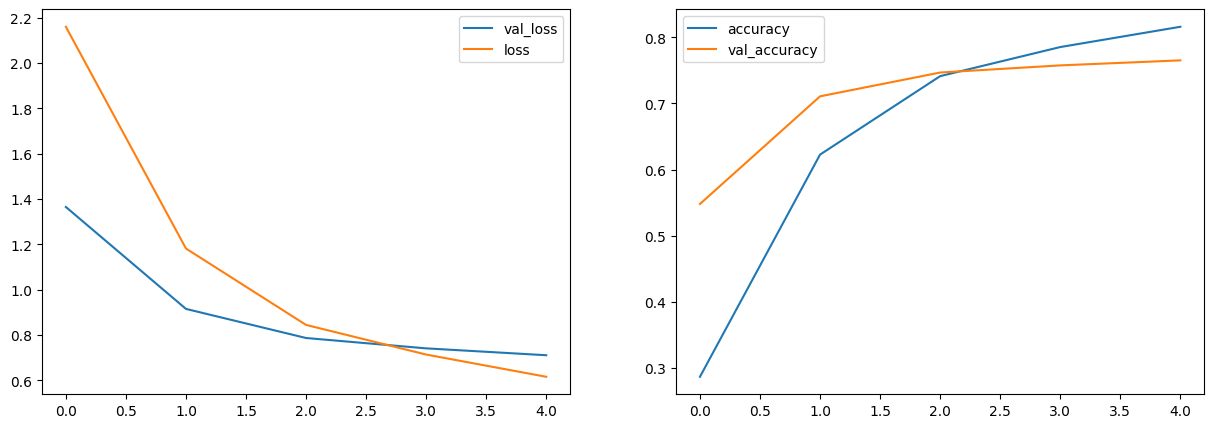

In [ ]:
# plot loss and accuracy curves
with open("help_function_1.py" , "wb") as file :
  file.write(requests.get("https://raw.githubusercontent.com/MohamadRacer/Tensorflow/main/plot_loss_acc.py").content)
from help_function_1 import plot_loss_acc
plot_loss_acc(results = resnet_result)

**EfficientNetB0 Model**

In [ ]:
# 1 . create model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes = 10)
# 2 . compile model
efficientnet_model.compile(loss = tf.keras.losses.categorical_crossentropy ,
                           optimizer = tf.keras.optimizers.Adam() ,
                           metrics = ["accuracy"])
# 3 . fit model
efficientnet_result  = efficientnet_model.fit(epochs = 5 ,
                                              x = train_data ,
                                              steps_per_epoch = len(train_data) ,
                                              validation_data = test_data ,
                                              validation_steps = len(test_data) ,
                                              callbacks = [tensorboard_callback_function(dir_name = "tensorflow_hub",
                                                                                         expriment_name = "efficientnetb0")])

Saving TensorBoard log files to tensorflow_hub/efficientnetb020230901-111728
Epoch 1/5
24/24 [==============================] - 34s 906ms/step - loss: 1.9719 - accuracy: 0.3440 - val_loss: 1.4178 - val_accuracy: 0.6808
Epoch 2/5
24/24 [==============================] - 19s 783ms/step - loss: 1.2449 - accuracy: 0.7240 - val_loss: 0.9680 - val_accuracy: 0.7808
Epoch 3/5
24/24 [==============================] - 18s 775ms/step - loss: 0.9133 - accuracy: 0.7973 - val_loss: 0.7670 - val_accuracy: 0.8228
Epoch 4/5
24/24 [==============================] - 18s 758ms/step - loss: 0.7533 - accuracy: 0.8253 - val_loss: 0.6641 - val_accuracy: 0.8460
Epoch 5/5
24/24 [==============================] - 17s 700ms/step - loss: 0.6645 - accuracy: 0.8347 - val_loss: 0.6000 - val_accuracy: 0.8444


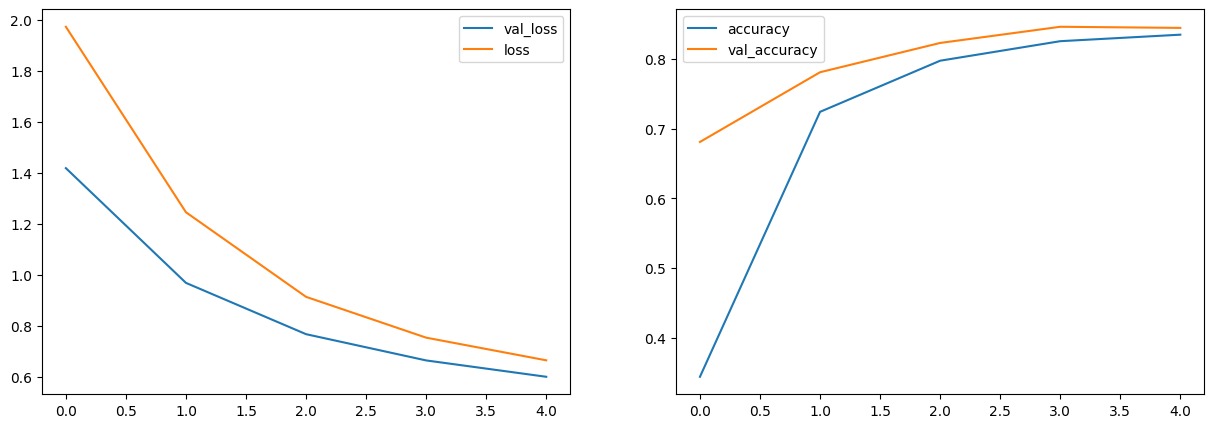

In [ ]:
plot_loss_acc(results = efficientnet_result)

### 2. 3  A Glance at models

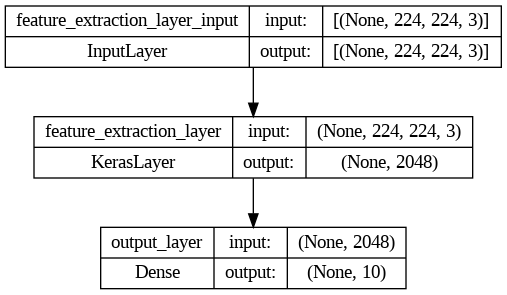

In [ ]:
# model shapes
from tensorflow.keras.utils import plot_model
plot_model(model_resnet , show_shapes = True)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


⚡ Different types of transfer learning :

* `As is ` -  use an existing model with no changes
* `Feature extraction` - use pre-learned pattern of an existing model and adjusting output shape for our own problem
* `Fine-tuning` - use pre-learned patterns of an existing model and fine-tunning all or  ost of underlying patterns


## Compare model Results using TensorBoard

**Note ❗**

>when you upload things to [TensorBoard Dev](https://tensorboard.dev/) your expriments are public so if we are working on a project that its expriments must be private we should not upload them .

In [ ]:
# upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two diffrent tensorflow hub feature extraction layer model architecture with 10% of 101 food data set" \
  --one_shot

2023-09-01 11:19:33.714629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   KTZG-MMZJ

KTZG-MMZJ
KTZG-MMZJ


New experiment created. View your TensorBoard at: https://

In [ ]:
# checking our tensorboard expriments uploaded
!tensorboard dev list

2023-09-01 11:24:33.679438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/xx5BuaHLQjiO7etRDeuoRw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diffrent tensorflow hub feature extraction layer model architecture with 10% of 101 food data set
	Id                   xx5BuaHLQjiO7etRDeuoRw
	Created              2023-09-01 11:22:29 (2 minutes ago)
	Updated              2023-09-01 11:22:34 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5934984
Total: 1 experiment(s)


In [ ]:
# delete an expriment
!tensorboard dev delete --expriment_id

2023-09-01 11:22:38.435999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard
       [-h]
       [--helpfull]
       {serve,dev}
       ...
tensorboard: error: unrecognized arguments: --expriment_id


now our tensorboard expriments are accesable at : https://tensorboard.dev/experiment/xx5BuaHLQjiO7etRDeuoRw/